In [1]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf, linewidth=np.nan)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))

pandas : 1.5.1
numpy : 1.22.3
matplotlib : 3.6.2
seaborn : 0.12.1
sklearn : 1.1.3
imblearn : 0.9.1


In [27]:
# Dataset field names
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
dfkdd_train = pd.read_table("KDDTrain.txt", sep=",", names=datacols) # change path to where the dataset is located.
dfkdd_train = dfkdd_train[['src_bytes','dst_host_srv_count','service','dst_bytes','num_outbound_cmds','attack']] # removes an unwanted extra field

# Load NSL_KDD test dataset
dfkdd_test = pd.read_table("KDDTest.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test[['src_bytes','dst_host_srv_count','service','dst_bytes','num_outbound_cmds','attack']]

In [28]:
# View train data
dfkdd_train.head(3)

,src_bytes,dst_host_srv_count,service,dst_bytes,num_outbound_cmds,attack
0,491,25,ftp_data,0,0,normal
1,146,1,other,0,0,normal
2,0,26,private,0,0,neptune


In [29]:
# train set dimension
print('Train set dimension: {} rows, {} columns'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

Train set dimension: 125973 rows, 6 columns


In [30]:
# View test data
dfkdd_test.head(3)

,src_bytes,dst_host_srv_count,service,dst_bytes,num_outbound_cmds,attack
0,0,10,private,0,0,neptune
1,0,1,private,0,0,neptune
2,12983,86,ftp_data,0,0,normal


In [31]:
# test set dimension
print('Test set dimension: {} rows, {} columns'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))

Test set dimension: 22544 rows, 6 columns


In [32]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [33]:
# Apply attack class mappings to the dataset
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [34]:
# Drop attack field from both train and test data
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [35]:
# View top 3 train data 
dfkdd_train.head(3)

,src_bytes,dst_host_srv_count,service,dst_bytes,num_outbound_cmds,attack_class
0,491,25,ftp_data,0,0,Normal
1,146,1,other,0,0,Normal
2,0,26,private,0,0,DoS


In [25]:
# Descriptive statistics
dfkdd_train.describe()

,src_bytes,dst_host_srv_count,dst_bytes
count,1.259730e+05,125973.000000,1.259730e+05
mean,4.556674e+04,115.653005,1.977911e+04
std,5.870331e+06,110.702741,4.021269e+06
min,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,10.000000,0.000000e+00
50%,4.400000e+01,63.000000,0.000000e+00
75%,2.760000e+02,255.000000,5.160000e+02
max,1.379964e+09,255.000000,1.309937e+09


In [36]:
dfkdd_train['num_outbound_cmds'].value_counts()
dfkdd_test['num_outbound_cmds'].value_counts()

0    22544
Name: num_outbound_cmds, dtype: int64

In [37]:
# 'num_outbound_cmds' field has all 0 values. Hence, it will be removed from both train and test dataset since it is a redundant field.
dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [38]:
# Attack Class Distribution
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


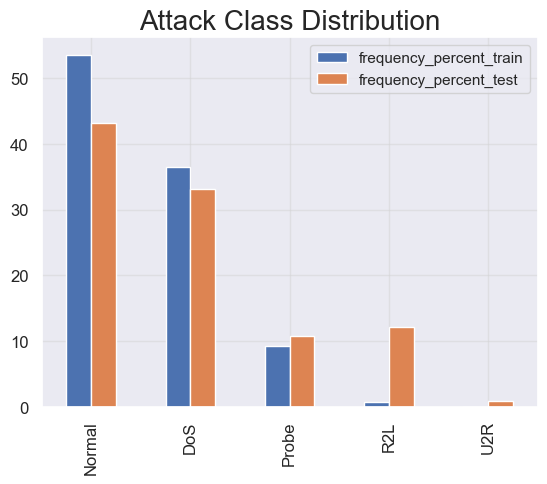

In [39]:
# Attack class bar plot
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [40]:
dfkdd_train.head()

,src_bytes,dst_host_srv_count,service,dst_bytes,attack_class
0,491,25,ftp_data,0,Normal
1,146,1,other,0,Normal
2,0,26,private,0,DoS
3,232,255,http,8153,Normal
4,199,255,http,420,Normal


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [42]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['attack_class'], axis=1)
enctest = testcat.drop(['attack_class'], axis=1)

cat_Ytrain = traincat[['attack_class']].copy()
cat_Ytest = testcat[['attack_class']].copy()

In [43]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

# define columns and extract encoded train set for sampling 
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass

# reshape target column to 1D array shape  
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# apply the random over-sampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})


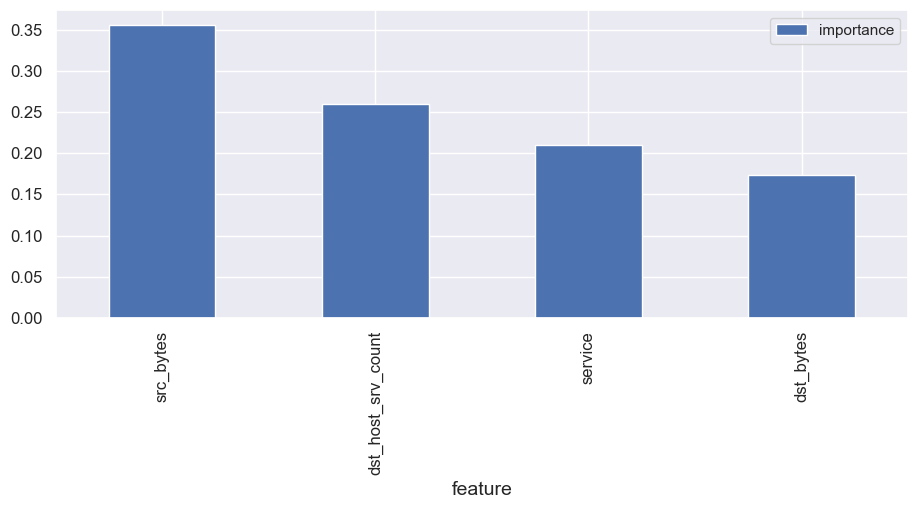

In [44]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_res, y_res);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [45]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_res, y_res)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), refclasscol)]
selected_features = [v for i, v in feature_map if i==True]

In [70]:
selected_features

['src_bytes', 'dst_host_srv_count', 'dst_bytes', 'service']

In [71]:
# define columns to new dataframe
newcol = list(refclasscol)
newcol.append('attack_class')

# add a dimension to target
new_y_res = y_res[:, np.newaxis]

# create a dataframe from sampled data
res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol) 

# create test dataframe
reftest = pd.concat([sc_testdf, testcat], axis=1)
reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
#reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
#reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)

res_df.shape
reftest.shape

(22544, 5)

In [72]:
from collections import defaultdict
classdict = defaultdict(list)

# create two-target classes (normal class and an attack class)  
attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]

def create_classdict():
    '''This function subdivides train and test dataset into two-class attack labels''' 
    for j, k in normalclass: 
        for i, v in attacklist: 
            restrain_set = res_df.loc[(res_df['attack_class'] == k) | (res_df['attack_class'] == v)]
            classdict[j +'_' + i].append(restrain_set)
            # test labels
            reftest_set = reftest.loc[(reftest['attack_class'] == k) | (reftest['attack_class'] == v)]
            classdict[j +'_' + i].append(reftest_set)
        
create_classdict()

In [73]:
for k, v in classdict.items():
    k

In [74]:
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'

In [75]:
import scipy

In [76]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

Xresdf = pretrain 
newtest = pretest

Xresdfnew = Xresdf[selected_features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()

Xtest_features = newtest[selected_features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtestcat = Xtest_features[['service']].copy()


# Fit train data
enc.fit(Xresdfcat)

# Transform train data
X_train_1hotenc = enc.transform(Xresdfcat).tolist()

       
# Transform test data
X_test_1hotenc = enc.transform(Xtestcat).tolist()


X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1) 

y_train = Xresdf[['attack_class']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack_class']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)

In [77]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
#KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
#KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
#LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
#LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
#BNB_Classifier = BernoulliNB()
#BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train);
            
# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);  

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier), 
#                  ('Decision Tree Classifier', DTC_Classifier), 
#                  ('KNeighborsClassifier', KNN_Classifier), 
#                  ('LogisticRegression', LGR_Classifier)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train, Y_train);

In [78]:
mlp_prdict_probability = DTC_Classifier.predict_proba(X_test)
mlp_prdict_probability

array([[1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.167, 0.833],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.75 , 0.25 ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1. 

In [79]:
# Prediction on test data
mlp_test_predict = DTC_Classifier.predict(X_test)

# Prediction on training data
mlp_train_predict = DTC_Classifier.predict(X_train)

In [80]:
DTC_Classifier.predict([[0,1,1]])

ValueError: X has 3 features, but DecisionTreeClassifier is expecting 68 features as input.

In [62]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix
mlp_train_accuracy = accuracy_score(mlp_train_predict,y_train)
print("Training accuracy of MLP model is:",mlp_train_accuracy*100)
print("Classification report of training:"'\n',classification_report(mlp_train_predict,y_train))

Training accuracy of MLP model is: 99.63990318221641
Classification report of training:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     67756
         1.0       0.99      1.00      1.00     66930

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686



In [63]:
mlp_test_accuracy = accuracy_score(mlp_test_predict,y_test)
print("Testing accuracy of MLP model is:",mlp_test_accuracy*100)
print("Classification report of testing:"'\n',classification_report(mlp_test_predict,y_test))

Testing accuracy of MLP model is: 79.678490302289
Classification report of testing:
               precision    recall  f1-score   support

         0.0       0.69      0.81      0.75      6341
         1.0       0.88      0.79      0.83     10828

    accuracy                           0.80     17169
   macro avg       0.78      0.80      0.79     17169
weighted avg       0.81      0.80      0.80     17169



In [67]:
import pickle

file = open('intdet_model.pkl' ,'wb')
pickle.dump(model,file)

In [55]:
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
#models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
#models.append(('KNeighborsClassifier', KNN_Classifier))
#models.append(('LogisticRegression', LGR_Classifier))
#models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_DoS Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9959535451535599

Model Accuracy:
 0.9963990318221642

Confusion matrix:
 [[67307    36]
 [  449 66894]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     67343
         1.0       1.00      0.99      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686




In [56]:
model = []

model.append(('Decision Tree Classifier', DTC_Classifier))


for i, v in model:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_DoS Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9959535451535599

Model Accuracy:
 0.9963990318221642

Confusion matrix:
 [[67307    36]
 [  449 66894]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     67343
         1.0       1.00      0.99      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686




In [57]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} {} Model Test Results =============================='.format(grpclass, i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Normal_DoS Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.7967849030228901

Confusion matrix:
 [[5155 2303]
 [1186 8525]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.69      0.75      7458
         1.0       0.79      0.88      0.83      9711

    accuracy                           0.80     17169
   macro avg       0.80      0.78      0.79     17169
weighted avg       0.80      0.80      0.79     17169




In [58]:
import pickle

file = open('int_det_model.pkl' ,'wb')
pickle.dump(model,file)